# Superdense Coding

This notebook demonstrates the Superdense Coding (SDC) protocol. We first use Qiskit's simulator to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Superdense Coding and Quantum Teleportation](#difference)
2. [The Process](#process)    
    2.1 [Step 1](#step1)    
    2.2 [Step 2](#step2)    
    2.3 [Step 3](#step3)
3. [Simulating the Superdense Coding Protocol](#simulating)    
    3.1 [3.1 Visualizing Our Measurements](#visualising)    
4. [Superdense Coding on a Real Quantum Computer](#real_qc)


## 1. The Difference between Superdense Coding and Quantum Teleportation <a id='difference'></a>

Quantum teleportation and superdense coding are closely related, to avoid confusion we need to clarify the difference.

Quantum teleportation is a process by which the state of qubit ($|\psi\rangle$) can be transmitted from one location to another, using two bits of classical communication and a Bell pair. In other words, we can say it is a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding is a procedure that allows someone to send two classical bits to another party using just a single qubit of communication.

| Teleportation                                     | Superdense Coding                                    |
|:-------------------------------------------------:|:----------------------------------------------------:|
| Transmit one<br>qubit using two<br>classical bits | Transmit two<br>classical bits<br>using one<br>qubit |


The teleportation protocol can be thought of as a flipped version of the superdense coding protocol, in the sense that Alice and Bob merely “swap their equipment.”



## 2. The Process <a id='process'></a>

![image1](images/superdense.jpg)

### 2.1 Step 1 <a id='step1'></a>
The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $|0\rangle$. He applies Hadamard gate ($H$) to the first qubit to create superposition. He then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier. 

#### Outcome States

Charlie first applies a Hadamard gate. 

When the H-gate is applied to first qubit, it creates superposition and we get the state:


$$|0+\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$$



Then Charlie applies the CNOT gate. The CNOT gate entangles both qubits, i.e. it flips the target if the control is $|1\rangle$. Note that the control qubit is our rightmost qubit.



$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$



### 2.2 Step 2 <a id='step2'></a>

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:


#### Encoding Rules for Superdense Coding (Alice protocol):

<!--- Table does not render properly when built to html. Replaced with image
| Intended Message | Applied Gate | Resulting State ($\cdot\sqrt{2}$)|
|:----------------:|:------------:|:--------------------------------:|
|00                |$I$           | $|00\rangle + |11\rangle$        |
|10                |$X$           | $|01\rangle + |10\rangle$        |
|01                |$Z$           | $|00\rangle - |11\rangle$        |
|11                |$ZX$          | $-|01\rangle + |10\rangle$       |
-->


![image2](images/superdense_table1.png)<br>


Thus if she wants to send a `00`, she does nothing to her qubit (apply the identity ($I$) gate). If she sends a `10`, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate, then sends her qubit to Bob for the final step in the process.


### 2.3 Step 3 <a id='step3'></a>

Bob receives Alice's qubit (rightmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the rightmost qubit as control and the leftmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

<!--- Table does not render properly when built to html. Replaced with image
| Bob Receives:              | After CNOT-gate:           |  After H-gate:  |
|:--------------------------:|:--------------------------:|:---------------:|
| $|00\rangle + |11\rangle$  | $|00\rangle + |01\rangle$  |  $|00\rangle$   |
| $|01\rangle + |10\rangle$  | $|11\rangle + |10\rangle$  |  $|10\rangle$   |
| $|00\rangle - |11\rangle$  | $|00\rangle - |01\rangle$  |  $|01\rangle$   |
| $-|01\rangle + |10\rangle$ | $-|11\rangle + |10\rangle$ | $-|11\rangle$   |
-->

![image3](images/superdense_table2.png)<br>

When Bob performs the measurements, he is certain to get the message Alice sent him. Note that the last outcome has a negative sign $-|11\rangle$, writing it as $|11\rangle$ is also correct as this is global phase and is not measureable.


## 3. Simulating the Superdense Coding Protocol <a id='simulating'></a>

In [1]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

We saw that to create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that takes a `QuantumCircuit` and entangles the qubits with indices `a` and `b`:

In [2]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b)
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

Next we need to encode our message. We saw that there were four possible messages we could send: `00`, `10`, `01` or `11`. Let's create a function that takes this message and applies the appropriate gates for us:

In [3]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

Finally, we need to decode our message, we saw we could do this using a CNOT followed by a H-gate. Let's create a function that does this for us too:

In [4]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

Finally, we can put this together to complete our protocol.

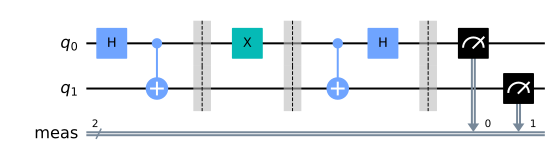

In [5]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

### 3.1 Visualizing Our Measurements <a id='visualising'></a>

{'10': 1024}


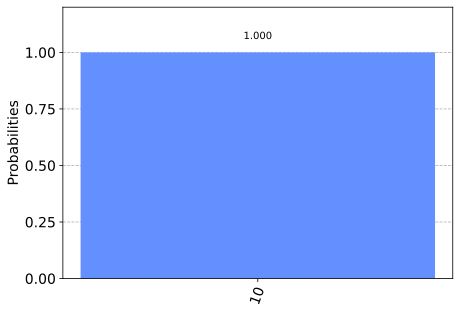

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Our simulator simulates a perfect quantum computer. We can see that, without errors, we get a 100% chance of measuring the correct message.

## 4. Superdense Coding on a Real Quantum Computer <a id='real_qc'></a>


We can now see this working on a real quantum computer. First, we want to load our account to get the least busy quantum system:

In [7]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_montreal


In [8]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


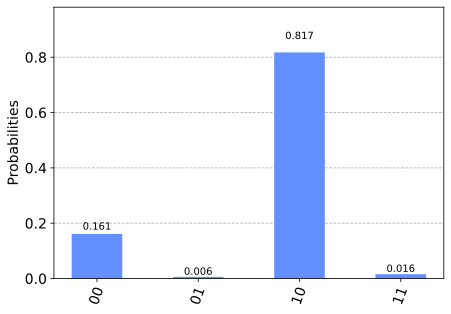

In [9]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

As we see that there are a few results from the other three states when run in a real quantum computer. These are due to errors in the gates and qubit decoherence. We will learn more about these errors in later sections.

In [10]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 81.74%


In [11]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}